In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stat
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
#import hvplot.pandas
%matplotlib inline
from sklearn import metrics
from numpy.random import seed
seed(1)
from tensorflow import random
tf.set_random_seed(2)
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
import os 
import csv
from matplotlib.dates import DateFormatter
import math
import time
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, Conv2D, MaxPooling2D,MaxPooling1D,Flatten, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from datetime import datetime
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [13]:
cpy = pd.read_csv('Company.csv')
cpy_tweet = pd.read_csv('Company_Tweet.csv')
tweet = pd.read_csv('Tweet.csv')
tweets = pd.merge(tweet,cpy_tweet,on='tweet_id',how='inner')
tweets['date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: datetime.fromtimestamp(date).date()))

In [15]:
tweets = tweets.drop(['tweet_id'],axis=1)

The "writer" column is the only column with missing data. Since we are not likely to use this column, I decided to ignore the missing value for now.

In [16]:
tweets.isna().sum()
tweet = tweets.copy()
tweet["sentiment_score"] = ''
tweet["Negative"] = ''
tweet["Neutral"] = ''
tweet["Positive"] = ''
tweet.head()

,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date,sentiment_score,Negative,Neutral,Positive
0,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2014-12-31,,,,
1,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2014-12-31,,,,
2,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2014-12-31,,,,
3,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2014-12-31,,,,
4,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2014-12-31,,,,


In [17]:
tweets.ticker_symbol.value_counts()

AAPL     1425013
TSLA     1096868
AMZN      718715
GOOG      392569
MSFT      375711
GOOGL     327569
Name: ticker_symbol, dtype: int64

In [18]:
aapl = tweet[tweets['ticker_symbol'] == 'AAPL']
tsla = tweet[tweets['ticker_symbol'] == 'TSLA']
amzn = tweet[tweets['ticker_symbol'] == 'AMZN']
msft = tweet[tweets['ticker_symbol'] == 'MSFT']
goog = tweet[tweets['ticker_symbol'] == 'GOOG']
googl = tweet[tweets['ticker_symbol'] == 'GOOGL']

In [9]:
def van_sent(sent_df):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    start_time = time.time()
    for indx, row in sent_df.T.iteritems():
        try:
            sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'body'])
            sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
            sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
            sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
            sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
            sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
        except TypeError:
            return (sent_df.loc[indexx, 'body'])
            print (indx)
            break
    elapsed_time = time.time() - start_time
    mins, secs = divmod(elapsed_time, 60)
    print(f"Elapsed time: {int(mins)} mins, {int(secs)} secs")
    return sent_df

In [19]:
aapl_sen = van_sent(aapl)
tsla_sen = van_sent(tsla)
msft_sen = van_sent(msft)
googl_sen = van_sent(googl)
amzn_sen = van_sent(amzn)

Elapsed time: 6 mins, 51 secs
Elapsed time: 5 mins, 47 secs
Elapsed time: 1 mins, 36 secs
Elapsed time: 1 mins, 23 secs
Elapsed time: 3 mins, 9 secs


In [34]:
def histg(sentiment_df, name):
    plt.hist(sentiment_df['sentiment_score'], bins=20)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.title("Histogram of Sentiment Scores " + name)
    plt.show()

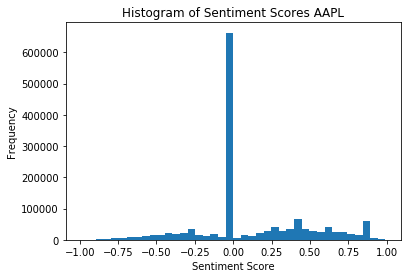

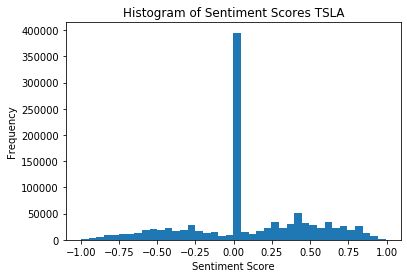

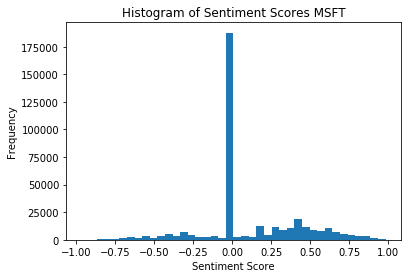

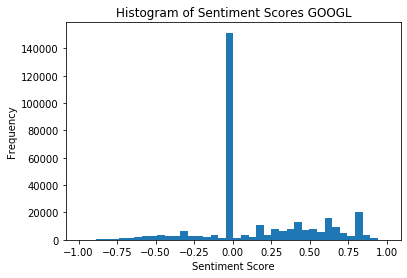

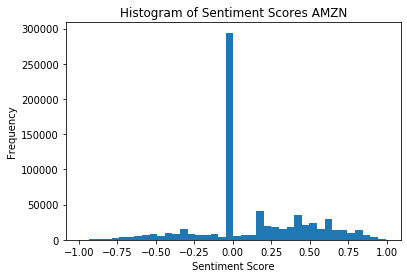

In [33]:
histg(aapl_sen, "AAPL")
histg(tsla_sen, "TSLA")
histg(msft_sen, "MSFT")
histg(googl_sen, "GOOGL")
histg(amzn_sen, "AMZN")

In [141]:
def clean(sent_df):
    sent_df['date'] = pd.to_datetime(sent_df['date'])
    sent_df['date'] = sent_df['date'].dt.date
    sent_df = sent_df.drop(columns=['comment_num', 'retweet_num','like_num','post_date','Negative', 'Positive', 'Neutral', 'writer'])
    twitter_df = sent_df.groupby([sent_df['date']]).mean()
    return twitter_df

In [142]:
aapl_sent = clean(aapl_sen)
googl_sent = clean(googl_sen)
tsla_sent = clean(tsla_sen)
amzn_sent = clean(amzn_sen)
msft_sent = clean(msft_sen)

In [169]:
amzn_sent.head()

,sentiment_score_x,sentiment_score_y,Close
date,,,
2015-02-17,0.178032,0.119618,375.430
2015-02-18,0.074313,0.118692,373.370
2015-02-19,0.103809,0.118266,378.995
2015-02-20,0.143284,0.121728,383.660
2015-02-23,0.148883,0.123407,380.140


In [167]:
def stock_getter(ticker, output, twitter_df):
    ts = TimeSeries(key='DIR3OHC94MGGVLVO', output_format ='pandas')
    data, metadata = ts.get_daily_adjusted(ticker ,outputsize= output)
    data.reset_index(inplace=True)
    #adjusting the stocks for the 2015-219
    data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
    data1 = data.loc[data['date'] >='2015-01-02']
    a_stock = data1.loc[data['date'] <= '2019-12-30']
    a_stock= a_stock.drop(columns=['5. adjusted close', "7. dividend amount", "8. split coefficient"])
    a_stock = a_stock.rename(columns={"date":"date", "1. open":"Open","2. high":"High", "3. low" : "Low", "4. close":"Close", 
                          "6. volume":"Volume"})
    a_stock.sort_values(by='date', inplace = True)
    a_stock.reset_index()
    a_stock['date'] = pd.to_datetime(a_stock['date'])
    a_stock['date']= a_stock['date'].dt.date
    final_df = a_stock.join(twitter_df, how = "left", on="date")
    datetime_series = pd.to_datetime(final_df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    dataset = final_df.set_index(datetime_index)
    dataset = dataset.sort_values(by='date')
    dataset = dataset.drop(columns='date')
    return a_stock, final_df, dataset

In [168]:
aapl_stock, aapl_df, aapl_df2 = stock_getter("AAPL", "full",aapl_sent)
tsla_stock, tsla_df, tsla_df2 = stock_getter("TSLA", "full",tsla_sent)
msft_stock, msft_df, msft_df2 = stock_getter("MSFT", "full",msft_sent)
amzn_stock, amzn_df, amzn_df2 = stock_getter("AMZN", "full",amzn_sent)
googl_stock, googl_df, googl_df2 = stock_getter("GOOGL", "full",googl_sent)

ValueError: columns overlap but no suffix specified: Index(['Close'], dtype='object')

In [146]:
tsla_df2

,Open,High,Low,Close,Volume,sentiment_score
2015-01-02,222.87,223.2500,213.2600,219.310,4764443.0,0.116348
2015-01-05,214.55,216.5000,207.1626,210.090,5368477.0,0.139528
2015-01-06,210.06,214.2000,204.2100,211.280,6261936.0,0.091023
2015-01-07,213.35,214.7800,209.7800,210.950,2968390.0,0.138047
2015-01-08,212.81,213.7999,210.0100,210.615,3442509.0,0.136253
...,...,...,...,...,...,...
2019-12-23,411.78,422.0100,410.0000,419.220,13332821.0,0.174764
2019-12-24,418.36,425.4700,412.6900,425.250,8054720.0,0.165843
2019-12-26,427.91,433.4800,426.3500,430.940,10648289.0,0.129348
2019-12-27,435.00,435.3100,426.1100,430.380,9956827.0,0.124667


In [80]:
def hist_prices(final_df, stock_name):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(final_df['date'], final_df['Close'], color='#008B8B')
    ax.set(xlabel="date", ylabel="USD", title=f"{stock_name} Stock Price")
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.show()

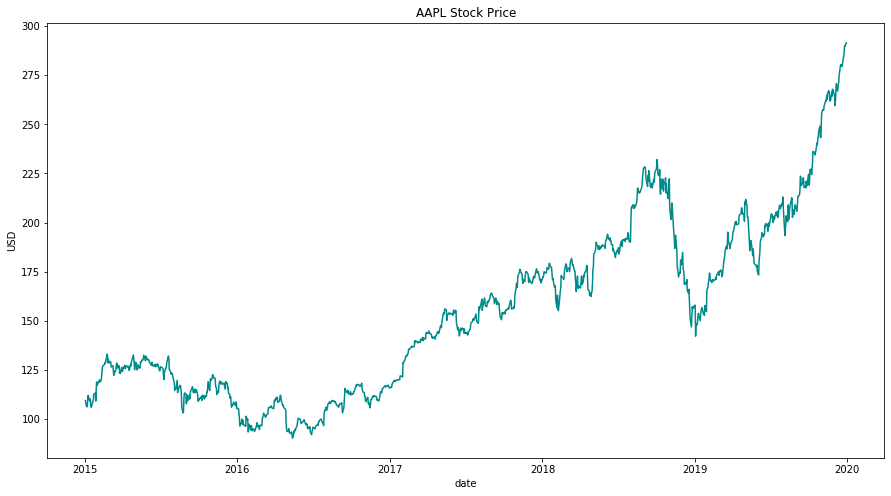

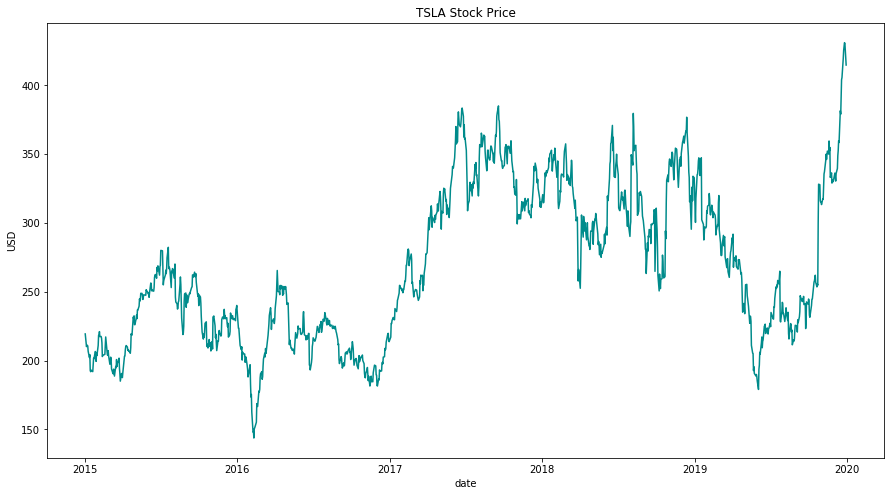

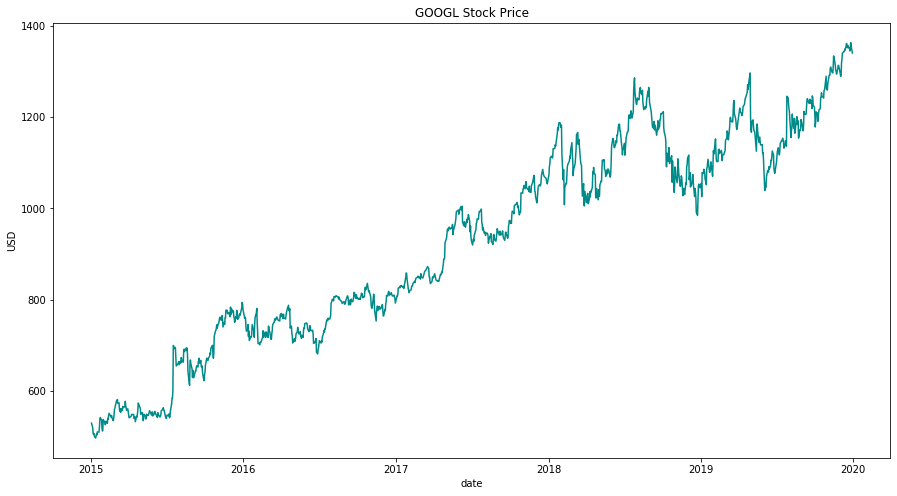

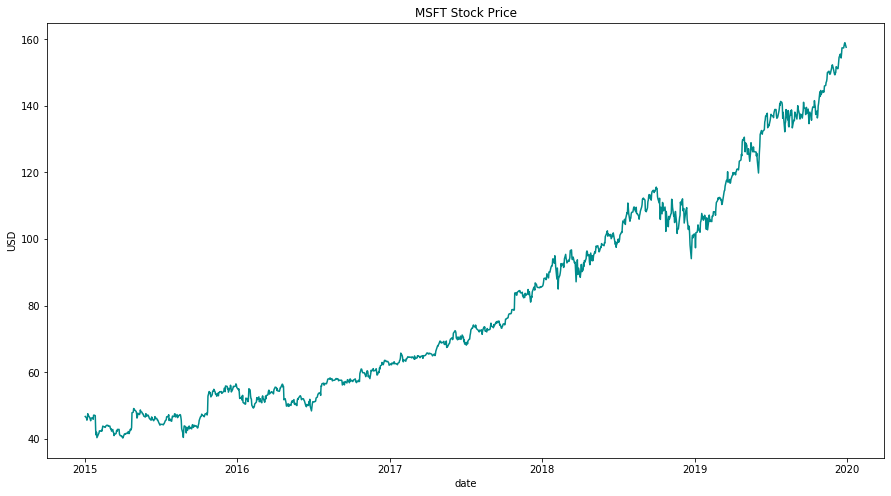

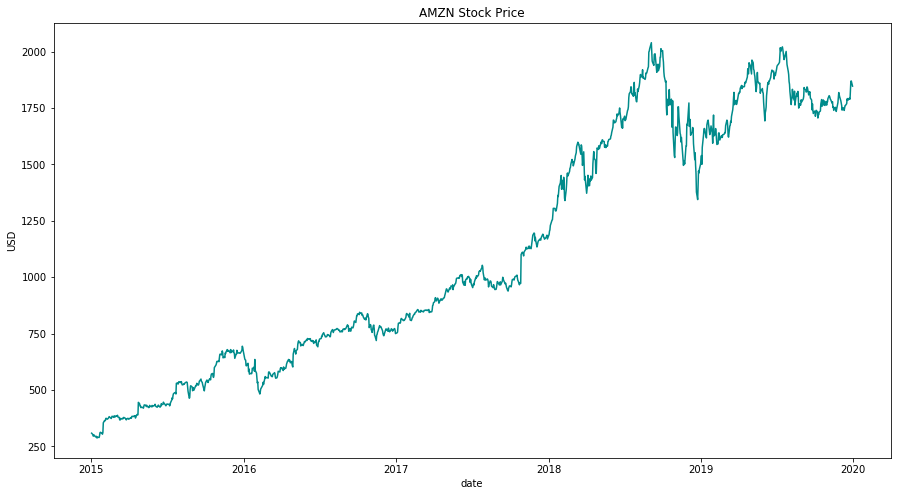

In [44]:
hist_prices(aapl_df, "AAPL")
hist_prices(tsla_df, "TSLA")
hist_prices(googl_df, "GOOGL")
hist_prices(msft_df, "MSFT")
hist_prices(amzn_df, "AMZN")


In [147]:
def sentiment_overtime(tweets, stock, title):
    tweets = tweets.reset_index()
    tweets = tweets.rename(columns={"index": "date"})
    visual = tweets.groupby('date')['sentiment_score'].mean().shift(-1).rolling(31).mean().dropna()
    visual = visual.reset_index()
    corr_test = tweets.groupby('date')['sentiment_score'].mean().shift(-1).dropna()
    corr_test = corr_test.reset_index()
    corr, pval = stat.spearmanr(corr_test['sentiment_score'].reindex(stock.index), stock['Close'], nan_policy='omit')
    
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax2 = ax1.twinx()
    
    merged = pd.merge(corr_test, visual, on='date', how='outer')
    stock['date'] = pd.to_datetime(stock['date'])
    merged = pd.merge(merged, stock[['Close', 'date']], on='date', how='left')
    merged = merged.dropna(subset=['sentiment_score_x', 'sentiment_score_y', 'Close'])
    
    # subset data for only years 2015-2019
    merged = merged[(merged['date'].dt.year >= 2015) & (merged['date'].dt.year <= 2019)]
    ax1.plot(merged['date'], merged['sentiment_score_y'], label='Tweets Sentiment')
    ax2.plot(merged['date'], merged['Close'], color='orange', label='Share Price')

    ax2.set_title("Effects of "+title+" tweets to share price using Vander" +"\n Spearman correlation: corr={0:.5f} pval={1:.5f}".format(corr,pval))
    
    # set the x-axis of ax1 to the years in merged
    xticks = pd.date_range(start='2015-01-01', end='2019-12-31', freq='YS')
    xlabels = [d.strftime('%Y') for d in xticks]
    ax1.set_xticks(xticks, minor=False)
    ax1.set_xticklabels(xlabels, rotation=45)
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    plt.tight_layout()
    plt.show()
    return merged

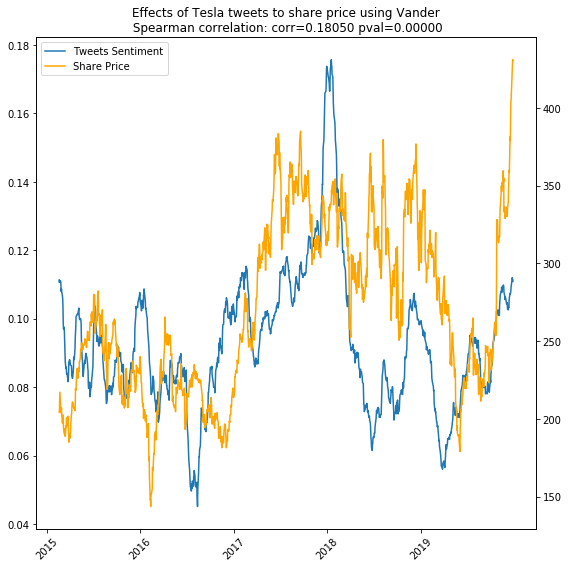

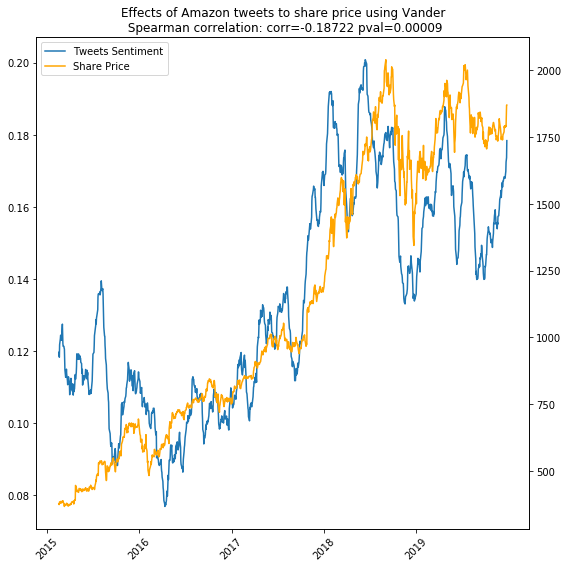

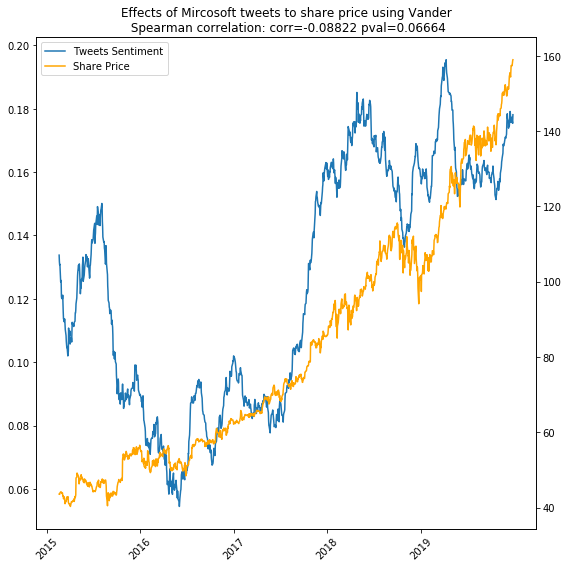

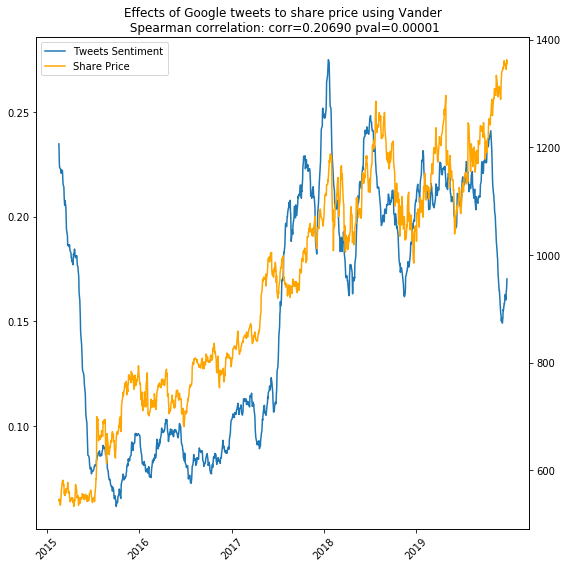

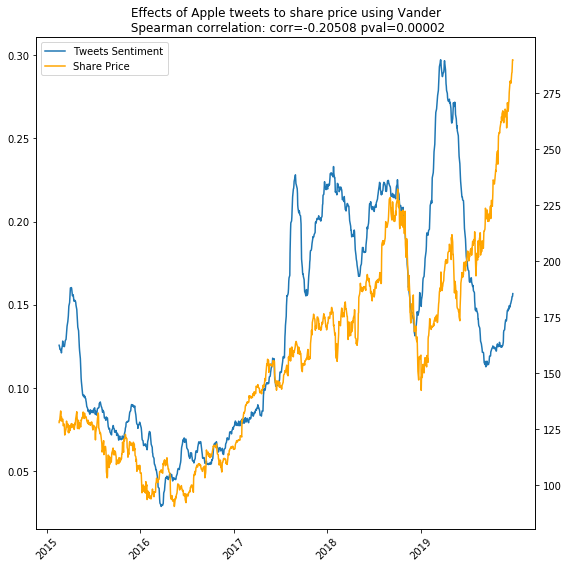

In [148]:
tsla_sen = sentiment_overtime(tsla_df2,tsla_stock,"Tesla");
amzn_sen = sentiment_overtime(amzn_df2,amzn_stock,"Amazon");
msft_sen =sentiment_overtime(msft_df2,msft_stock,"Mircosoft");
googl_sen = sentiment_overtime(googl_df2,googl_stock,"Google");
aapl_sen =sentiment_overtime(aapl_df2,aapl_stock,"Apple");

In [94]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    X_open = []
    X_senti = []
    X_corr = []
    y = []
    for i in range(len(df) - window):
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_open.append(close)
        X_senti.append(ts_polarity)
        X_corr.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_open,X_senti,X_corr)), np.array(y).reshape(-1, 1)

In [95]:
def data_train(sent_stock):
# Predict Closing Prices using a 3 day window of previous closing prices
    window_size = 3
# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
    feature_col_number1 = 3
    feature_col_number2 = 5
    feature_col_number3 = 4
    target_col_number = 3
    X, y = window_data(sent_stock, window_size, feature_col_number1,feature_col_number2, feature_col_number3, target_col_number)
    X_split = int(0.7 * len(X))
    y_split = int(0.7 * len(y))
    X_train = X[: X_split]
    X_test = X[X_split:]
    y_train = y[: y_split]
    y_test = y[y_split:]
    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()
    x_train_scaler.fit(X_train)
    y_train_scaler.fit(y_train)
    X_train = x_train_scaler.transform(X_train)
    y_train = y_train_scaler.transform(y_train)
    x_test_scaler.fit(X_test)
    y_test_scaler.fit(y_test)
    X_test = x_test_scaler.transform(X_test)
    y_test = y_test_scaler.transform(y_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_test, X_train, y_test, y_train,y_test_scaler

In [96]:
aapl_test, aapl_train, appl_testy, appl_trainy, aapl_test_scaler = data_train(aapl_df2)
tsla_test, tsla_train, tsla_testy, tsla_trainy, tsla_test_scaler = data_train(tsla_df2)
msft_test, msft_train, msft_testy, msft_trainy, msft_test_scaler = data_train(msft_df2)
googl_test, googl_train, googl_testy, googl_trainy, googl_test_scaler = data_train(googl_df2)
amzn_test, amzn_train, amzn_testy, amzn_trainy, amzn_test_scaler = data_train(amzn_df2)

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
def modelbuilder(X_test,X_train,y_test, y_train):
    model = Sequential()
    number_units = 9
    dropout_fraction = 0.2
    model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_fraction))
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=0)
    model.evaluate(X_test, y_test)
    predicted = model.predict(X_test)
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
    print('R-squared :', metrics.r2_score(y_test, predicted))
    return predicted


In [98]:
amzn_predicted = modelbuilder(amzn_test, amzn_train, amzn_testy, amzn_trainy)
aapl_predicted = modelbuilder(aapl_test, aapl_train, appl_testy, appl_trainy)
msft_predicted = modelbuilder(msft_test, msft_train, msft_testy, msft_trainy)
googl_predicted = modelbuilder(googl_test, googl_train, googl_testy, googl_trainy)
tsla_predicted = modelbuilder(tsla_test, tsla_train, tsla_testy, tsla_trainy)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
377/377 [==============================] - 0s 512us/sample - loss: 0.0075
Root Mean Squared Error: 0.08662737042986783
R-squared : 0.7656526604854611
377/377 [==============================] - 0s 679us/sample - loss: 0.0626
Root Mean Squared Error: 0.2501288100641066
R-squared : -0.4830198823294287
377/377 [==============================] - 0s 879us/sample - loss: 0.0046
Root Mean Squared Error: 0.0676267656125488
R-squared : 0.9272154776172843
377/377 [==============================] - 0s 1ms/sample - loss: 0.0155
Root Mean Squared Error: 0.12468963023115347
R-squared : 0.6659382987409914
377/377 [==============================] - 0s 1ms/sample - loss: 0.0184
Root Mean Squared Error: 0.13571930703020882
R-squared : 0.54546202049403


In [171]:
import holoviews as hv
import hvplot.pandas
def predictmodel(X_test, y_test, predicted, name, merged, y_test_scaler):
    # Recover the original prices instead of the scaled version
    predicted_prices = y_test_scaler.inverse_transform(predicted)
    real_prices = y_test_scaler.inverse_transform(y_test)
    # Create a DataFrame of Real and Predicted values
    real_prices = y_test_scaler.inverse_transform(y_test)
    real_prices = pd.Series(real_prices.ravel()).dropna().values
    merged = merged.iloc[-len(real_prices):].reset_index(drop=True)
    merged = merged.sort_index().reset_index()
    stocks =  pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index=merged[-len(real_prices):].index)
    xticks = pd.date_range(start='2015', end='2019', freq='YS')
    xlabels = [d.strftime('%Y') for d in xticks]
    plot = stocks.hvplot(title="Real vs Predicted values of Vander " + name, xticks=xticks, xlabel='Year', ylabel='Stock Price')
    plot.opts(yformatter="%.0f", height=380, width=400)
    return plot

In [172]:
import holoviews as hv
from bokeh.layouts import gridplot
from bokeh.plotting import show
df = predictmodel(googl_test, googl_testy, googl_predicted, "GOOGL", googl_sen, googl_test_scaler)
df1 = predictmodel(tsla_test, tsla_testy, tsla_predicted, "TSLA", tsla_sen, tsla_test_scaler)
df2 = predictmodel(amzn_test, amzn_testy, amzn_predicted, "AMZN", amzn_sen, amzn_test_scaler)
df3 = predictmodel(msft_test, msft_testy, msft_predicted, "MSFT", msft_sen, msft_test_scaler)
plot1 = hv.render(df)
plot2 = hv.render(df1)
plot3 = hv.render(df2)
plot4 = hv.render(df3)

grid = gridplot([[plot1, plot2], [plot3, plot4]], width=390, height=300)

# show the grid plot
show(grid)